# Denoising Autoencoder
In this notebook, you are going to build and train a denoising autoencoder. The purpose of an autoencoder, a form of neural network, is to develop codings for data. 

An autoencoder has two parts: an encoder and a decoder. The encoder modifies the input data and produces a representation for the input in a smaller dimension, and the decoding function reconstructs the input data from the encoded representation. 

A denoising autoencoder is an autoencoder that gets noisy data as input and tries to produce the denoised output for that input.

In [1]:
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim

**For this question, it's highly recommended to use a CUDA-enabled environment.**
We'll check for the availability of GPU and set `device` accordingly.

In [2]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))

## Preparing the data
You'll use [Fashion MNIST](https://en.wikipedia.org/wiki/Fashion_MNIST) dataset to train your DAE.

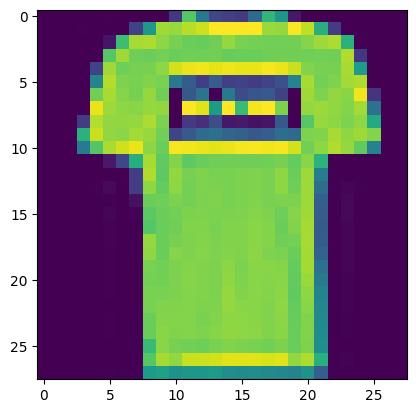

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


In [3]:
fm_train_set = datasets.FashionMNIST(root='./', train=True, download=True, transform=transforms.ToTensor())
fm_test_set = datasets.FashionMNIST(root='./', train=False, download=True, transform=transforms.ToTensor())

# For both the `fm_train_set` and `fm_test_set` only keep the 
# images and leave out the labels.
# Also, normalize the values to be between [0, 1].
##############################
# Your code goes here (5 points)
train_imgs = fm_train_set.data.float() / 255.0
test_imgs = fm_test_set.data.float() / 255.0
##############################

plt.imshow(train_imgs[1].unsqueeze(0).permute(1, 2, 0))
plt.show()
print(train_imgs.shape, test_imgs.shape)

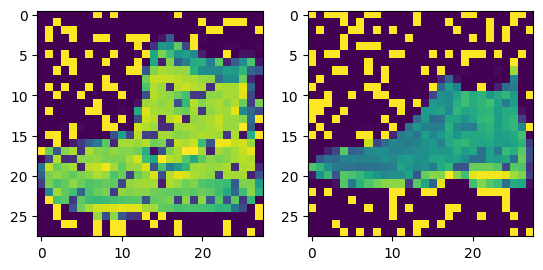

In [4]:
# For each image in our training and test sets,
# create a noisy version of the image.
# We'll use these noisy images as input data for the
# dataset we're going to create. The labels of this dataset
# would be the original images.
##############################
# Your code goes here (10 points)
# As mentioned in Quera, Salt and pepper noise is added and with erasing probability of 0.2
prob = 0.2
mask = torch.rand(train_imgs.size()) < prob
noisy_train_imgs = torch.where(mask, 1.0 - train_imgs, train_imgs)
mask = torch.rand(test_imgs.size()) < prob
noisy_test_imgs = torch.where(mask, 1.0 - test_imgs, test_imgs)
##############################
f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(noisy_train_imgs[0])
f.add_subplot(1, 2, 2)
plt.imshow(noisy_test_imgs[0])
plt.show()

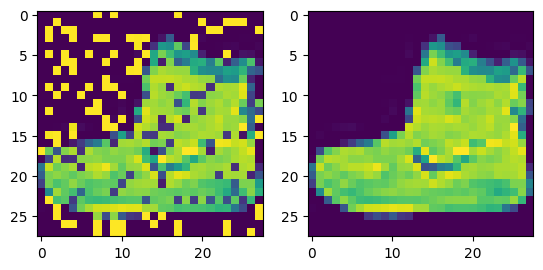

In [5]:
# Now we want to construct our new training and test sets.
# To do so, you'll use the noisy images you've created for each set
# as input for the new dataset and the original Fashion MNIST images as labels.

# Construct `training_set` (data, label) pairs.
##############################
# Your code goes here (10 points)
train_set = [(noisy_train_imgs[i], train_imgs[i]) for i in range(len(train_imgs))]
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(train_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(train_set[0][1])
plt.show()

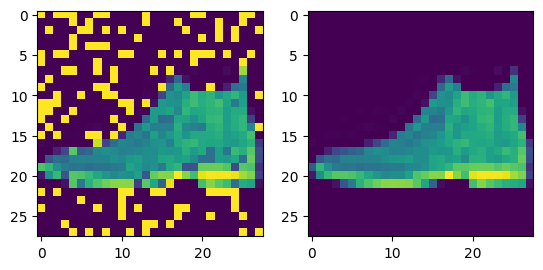

In [6]:
# Construct `test_set` (data, label) pairs.
##############################
# Your code goes here (5 points)
test_set = [(noisy_test_imgs[i], test_imgs[i]) for i in range(len(test_imgs))]
##############################

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.imshow(test_set[0][0]) 
f.add_subplot(1, 2, 2)
plt.imshow(test_set[0][1])
plt.show()

In [7]:
# Finally, create DataLoaders for the datasets.
# Use a batch size of 128 and enable shuffling.
##############################
# Your code goes here (5 points)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
test_loader = DataLoader(test_set, batch_size=128, shuffle=True)
##############################

train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x7fc5547b2dc0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fc5547b2880>)

## Creating the Model


In this part, you're going to create the DAE model.

In [8]:
# The encoder takes the input and outputs the `encoded representation`.
# Create the encoder using nn.Sequential (You can use the architecture 
# shown in this cell's output).
# Use Conv2d layers followed by ReLU.
# After conv2d layers, flatten the data and use linear layers to
# smoothly transform the output from conv2d layers into the encoded space.
# Set the encoded space dimensions to 10 * 1.
##############################
# Your code goes here (15 points)
encoder = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
    nn.ReLU(inplace=True),
    nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
    nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
    nn.ReLU(inplace=True),
    nn.Flatten(start_dim=1, end_dim=-1),
    nn.Linear(in_features=288, out_features=128, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=128, out_features=64, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=64, out_features=10, bias=True)
)
##############################
encoder

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
  (7): ReLU(inplace=True)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=288, out_features=128, bias=True)
  (10): ReLU(inplace=True)
  (11): Linear(in_features=128, out_features=64, bias=True)
  (12): ReLU(inplace=True)
  (13): Linear(in_features=64, out_features=10, bias=True)
)

In [9]:
# The decoder takes the encoded data generated by the encoder
# and outputs the original input.
# Create the decoder using nn.Sequential.
# Reverse the operations used in encoder.
##############################
# Your code goes here (15 points)

decoder = nn.Sequential(
    nn.Linear(in_features=10, out_features=64, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=64, out_features=128, bias=True),
    nn.ReLU(inplace=True),
    nn.Linear(in_features=128, out_features=288, bias=True),
    nn.ReLU(inplace=True),
    nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
    nn.ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2)),
    nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
    nn.BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
    nn.ReLU(inplace=True),
    nn.ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1)),
    nn.Sigmoid()  
)
##############################

Now we can construct the DAE by sequentially connecting the `encoder` and `decoder` networks.

In [10]:
DAE = nn.Sequential(encoder, decoder).to(device=device)

## Training the DAE

### Visualizing the Latent Space

During the training, we intend to visualize the *encoded representations* learned by the DAE every 10 epochs. You are going to use T-SNE for this purpose. In order to do so, you have to pass the selected samples to the encoder and retrieve the encoded vectors. Then you can visualize these vectors on a plane and colorize the points according to the class of object each represent.

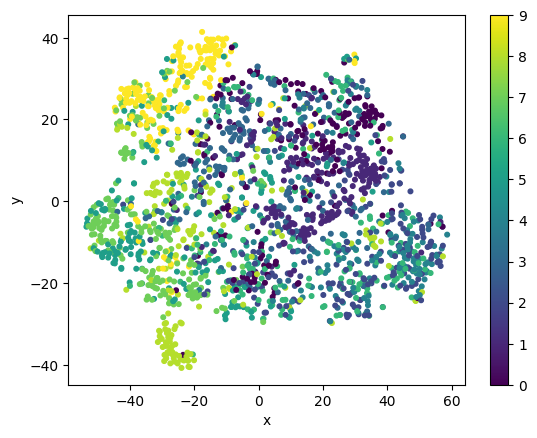

In [11]:
from sklearn.manifold import TSNE

def visualize():
  # Plot the encoded representations of the first 2000
  # images from `fm_train_set` on a plane.
  # You must first pass the images to
  # the encoder to get the encoded vectors, and then you
  # must transform these vectors to 2D space using TSNE
  # and plot the points.
  ##############################
  # Your code goes here (15 points)
  DAE.eval()
  
  images, labels = zip(*[fm_train_set[i] for i in range(2000)])
  images = torch.stack(images).to(device=device)
  encoded_vectors = DAE[0](images).squeeze().cpu().detach().numpy()

  tsne = TSNE(n_components=2)
  encoded_vectors_tsne = tsne.fit_transform(encoded_vectors)

  plt.scatter(encoded_vectors_tsne[:, 0], encoded_vectors_tsne[:, 1], c=labels, s=11)
  plt.xlabel('x')
  plt.ylabel('y')
  plt.colorbar()
  plt.show()
  ##############################

# Testing the function
visualize()

In [12]:
def train(n_epochs, optimizer, model, loss_fn, train_loader):
    model.train()  
    model.to(device)

    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            # Compute the output.
            # Use GPU for your data if possible.
            ##############################
            # Your code goes here (5 points)
            imgs = imgs.unsqueeze(1).to(device) 
            labels = labels.unsqueeze(1).to(device)
            outputs = model(imgs)
            ##############################

            # Using `loss_fn` and `optimizer`, compute the loss and do the backprop step.
            ##############################
            # Your code goes here (5 points)
            optimizer.zero_grad() 
            loss = loss_fn(outputs, imgs)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            ##############################
            
        print('Epoch {}, Training loss {}'.format(epoch, loss_train / len(train_loader)))
        # Every 10 epochs, we visualize the encoded representations.
        if epoch % 10 == 0:
          visualize()

Epoch 1, Training loss 0.12481204159796111
Epoch 2, Training loss 0.1163326612254704
Epoch 3, Training loss 0.11537880547392343
Epoch 4, Training loss 0.11495566657230036
Epoch 5, Training loss 0.11472182129936687
Epoch 6, Training loss 0.11454071625590578
Epoch 7, Training loss 0.11441994782513393
Epoch 8, Training loss 0.114315995783694
Epoch 9, Training loss 0.11423050432698305
Epoch 10, Training loss 0.11416780292543012


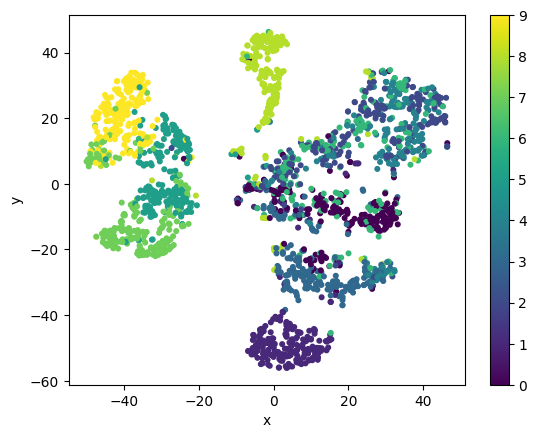

Epoch 11, Training loss 0.1140195103501206
Epoch 12, Training loss 0.11396187437432152
Epoch 13, Training loss 0.11389579222019293
Epoch 14, Training loss 0.11384729321386769
Epoch 15, Training loss 0.11381270277347647
Epoch 16, Training loss 0.11376848024155285
Epoch 17, Training loss 0.11373061934577376
Epoch 18, Training loss 0.11370260521038764
Epoch 19, Training loss 0.11366979234508359
Epoch 20, Training loss 0.11364921265001744


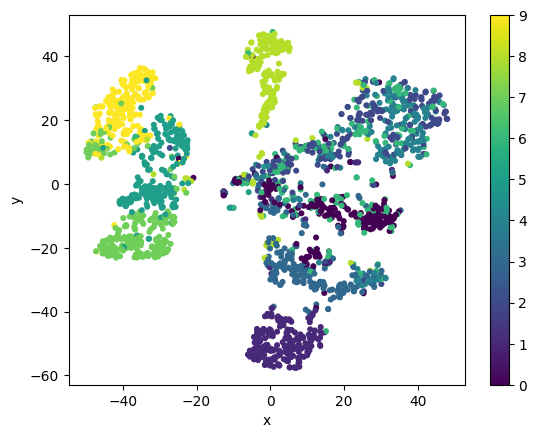

In [13]:
epochs = 20
# Train the DAE. use MSE as the loss function and 
# use Adam for the optimizer. Set the learning rate to 1e-3.
##############################
# Your code goes here (5 points)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(DAE.parameters(), lr=1e-3)
train(epochs, optimizer, DAE, loss_fn, train_loader)
##############################

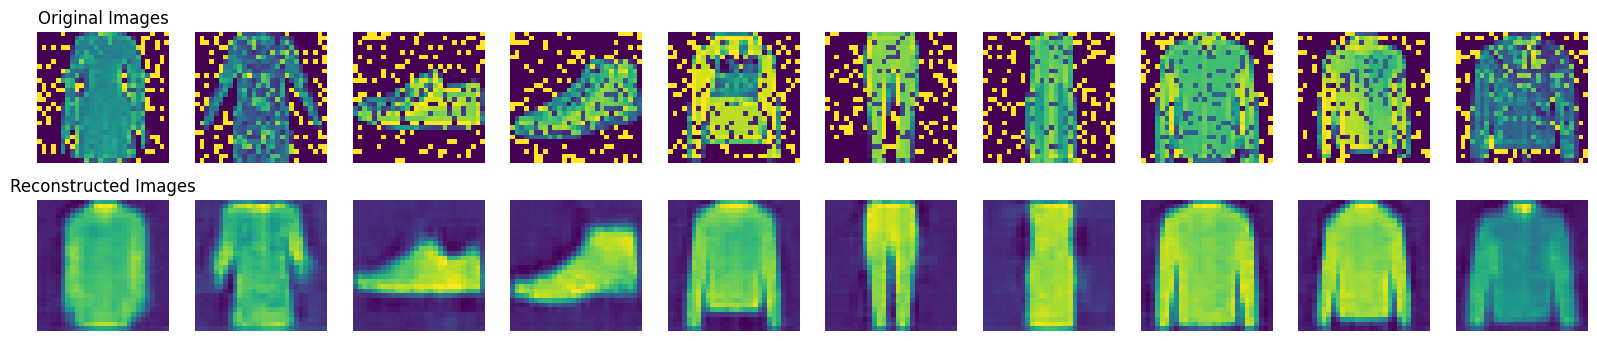

In [14]:
# Use 10 examples from the testing set to evaluate the 
# DAE's outputs visually.
##############################
# Your code goes here (5 points)

DAE.eval()

with torch.no_grad():
    data_iter = iter(test_loader)
    images, _ = next(data_iter)
    images = images[:10].unsqueeze(1).to(device)
    reconstructed_images = DAE(images)

    images = images.cpu().numpy()
    reconstructed_images = reconstructed_images.cpu().numpy()

    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    for i in range(10):
        axes[0, i].imshow(images[i].squeeze())
        axes[1, i].imshow(reconstructed_images[i].squeeze())
        axes[0, i].axis('off')
        axes[1, i].axis('off')
    axes[0, 0].set_title('Original Images')
    axes[1, 0].set_title('Reconstructed Images')
    plt.show()
##############################